## Classification of movie reviews

This NLP project is aim to build different classifiers for movie review datasets:

1. Binary classification problem with 5331 positive and 5331 negative snippets from http://www.cs.cornell.edu/people/pabo/movie-review-data </br>
2. Multi-class problem with data from Kaggle competition - Sentiment Analysis on Movie Reviews.
https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data </br>
The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset with five classes: </br>
0 - negative; 
1 - somewhat negative; 
2 - neutral; 
3 - somewhat positive; 
4 - positive;


In [21]:
import numpy as np
import pandas as pd
import math
import re
import collections
import random
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectPercentile, chi2

import tensorflow as tf
import keras
import matplotlib.pyplot as plt

## 1. Binary classification

In [22]:
## input data
file_pos = open("data/rt-polarity-pos.txt", "r", encoding="ISO-8859-1")
data_pos = file_pos.readlines()
file_neg = open("data/rt-polarity-neg.txt", "r", encoding="ISO-8859-1")
data_neg = file_neg.readlines()
corpus = data_neg + data_pos
y = np.array([0]*5331 + [1]*5331)

In [23]:
## 10 sample of original dataset
for i in range(10):
    print(i+1, corpus[i], end="") 

1 simplistic , silly and tedious . 
2 it's so laddish and juvenile , only teenage boys could possibly find it funny . 
3 exploitative and largely devoid of the depth or sophistication that would make watching such a graphic treatment of the crimes bearable . 
4 [garbus] discards the potential for pathological study , exhuming instead , the skewed melodrama of the circumstantial situation . 
5 a visually flashy but narratively opaque and emotionally vapid exercise in style and mystification . 
6 the story is also as unoriginal as they come , already having been recycled more times than i'd care to count . 
7 about the only thing to give the movie points for is bravado -- to take an entirely stale concept and push it through the audience's meat grinder one more time . 
8 not so much farcical as sour . 
9 unfortunately the story and the actors are served with a hack script . 
10 all the more disquieting for its relatively gore-free allusions to the serial murders , but it falls down in it

In [24]:
## Clean text

def clean_sentence(text, rm_stopwords=True):
    """
    - Tokenize the words.
    - Remove all punctuation from words.
    - Remove all words that are not purely comprised of alphabetical characters.
    - Remove all words that are known stop words.
    - Get stem of the words
    - Remove all words that have a length <= 1 character.
    """
    
    text=text.lower()
    tokens = text.split()
    
    table = str.maketrans("","", string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    
    tokens = [w for w in tokens if w.isalpha()]
    
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]

#    stemmer = SnowballStemmer('english')
#    tokens = [stemmer.stem(w) for w in tokens]
    
    tokens = [w for w in tokens if len(w) > 1]

    return tokens

clean_corpus = []
clean_words = []
for s in corpus:
    clean_words.append(clean_sentence(s))
    clean_corpus.append(" ".join(clean_sentence(s)))

print(clean_words[:10])
print(clean_corpus[:10])
print("Length of X:", len(clean_corpus))

[['simplistic', 'silly', 'tedious'], ['laddish', 'juvenile', 'teenage', 'boys', 'could', 'possibly', 'find', 'funny'], ['exploitative', 'largely', 'devoid', 'depth', 'sophistication', 'would', 'make', 'watching', 'graphic', 'treatment', 'crimes', 'bearable'], ['garbus', 'discards', 'potential', 'pathological', 'study', 'exhuming', 'instead', 'skewed', 'melodrama', 'circumstantial', 'situation'], ['visually', 'flashy', 'narratively', 'opaque', 'emotionally', 'vapid', 'exercise', 'style', 'mystification'], ['story', 'also', 'unoriginal', 'come', 'already', 'recycled', 'times', 'id', 'care', 'count'], ['thing', 'give', 'movie', 'points', 'bravado', 'take', 'entirely', 'stale', 'concept', 'push', 'audiences', 'meat', 'grinder', 'one', 'time'], ['much', 'farcical', 'sour'], ['unfortunately', 'story', 'actors', 'served', 'hack', 'script'], ['disquieting', 'relatively', 'gorefree', 'allusions', 'serial', 'murders', 'falls', 'attempts', 'humanize', 'subject']]
['simplistic silly tedious', 'lad

In [25]:
X = np.array(clean_corpus)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y)

print("No. train-test samples:", y_train.shape[0], y_test.shape[0])

No. train-test samples: 8529 2133


### Bag of words model

- tfidf + NaiveBayers
- tfidf + NeuralNet

In [26]:
# text vectorization
vectorizer = TfidfVectorizer(max_df=0.9, decode_error='ignore', ngram_range=(1,2), stop_words="english")
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

print("After text vectorization,\ntraining set:", X_train_transformed.shape, 
      "\ntesting set:", X_test_transformed.shape)

## select 10% features based on chi2 stat
def reduce_dim(X_train, X_test, y_train, percentile):
    selector = SelectPercentile(chi2, percentile=percentile)
    selector.fit(X_train, y_train)
    X_train_reduced = selector.transform(X_train).toarray()
    X_test_reduced = selector.transform(X_test).toarray()
    return X_train_reduced, X_test_reduced

X_train_reduced, X_test_reduced = reduce_dim(X_train_transformed, 
                                             X_test_transformed, 
                                             y_train, percentile=10)

print("After dimension reduction,\ntraining set:", X_train_reduced.shape, 
      "\ntesting set:", X_test_reduced.shape)

After text vectorization,
training set: (8529, 84436) 
testing set: (2133, 84436)
After dimension reduction,
training set: (8529, 8443) 
testing set: (2133, 8443)


In [27]:
# model with Naive Bayes
clf = GaussianNB()
clf.fit(X_train_reduced, y_train)

print("Accuracy of train set: {:.2%}".format(clf.score(X_train_reduced, y_train)))
print("Accuracy of test set: {:.2%}".format(clf.score(X_test_reduced, y_test)))

Accuracy of train set: 93.54%
Accuracy of test set: 69.76%


In [28]:
# model with neural netword (1 hidden-layer)
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
Xtrain = tokenizer.texts_to_matrix(X_train, mode='freq')
Xtest = tokenizer.texts_to_matrix(X_test, mode='freq')
ytrain = y_train
ytest = y_test

#print(Xtrain.shape, Xtest.shape)

n_words = Xtrain.shape[1]
model = Sequential()
model.add(Dense(64, input_shape=(n_words,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(Xtrain, ytrain, validation_data=(Xtest, ytest), epochs=10, batch_size=64, verbose=2)
loss, acc = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Train on 8529 samples, validate on 2133 samples
Epoch 1/10
 - 8s - loss: 0.6856 - acc: 0.6087 - val_loss: 0.6686 - val_acc: 0.7365
Epoch 2/10
 - 6s - loss: 0.6290 - acc: 0.7763 - val_loss: 0.6055 - val_acc: 0.7436
Epoch 3/10
 - 5s - loss: 0.5308 - acc: 0.8350 - val_loss: 0.5448 - val_acc: 0.7529
Epoch 4/10
 - 5s - loss: 0.4375 - acc: 0.8628 - val_loss: 0.5069 - val_acc: 0.7562
Epoch 5/10
 - 5s - loss: 0.3623 - acc: 0.8904 - val_loss: 0.4886 - val_acc: 0.7618
Epoch 6/10
 - 5s - loss: 0.3031 - acc: 0.9137 - val_loss: 0.4813 - val_acc: 0.7628
Epoch 7/10
 - 5s - loss: 0.2567 - acc: 0.9322 - val_loss: 0.4824 - val_acc: 0.7661
Epoch 8/10
 - 5s - loss: 0.2199 - acc: 0.9443 - val_loss: 0.4902 - val_acc: 0.7614
Epoch 9/10
 - 5s - loss: 0.1883 - acc: 0.9542 - val_loss: 0.4965 - val_acc: 0.7595
Epoch 10/10
 - 7s - loss: 0.1626 - acc: 0.9632 - val_loss: 0.5075 - val_acc: 0.7604
Test Accuracy: 76.043132


### Word embedding

- Train word embedding + PCA + visualization
- embedding + LSTM
- embedding + CNN + LSTM

In [29]:
## train embedding with word2vec
from gensim.models import Word2Vec
import random

model = Word2Vec(clean_words, size=300, min_count=2)

In [30]:
import scipy.spatial as sp

words = list(model.wv.vocab)
final_embeddings = model[model.wv.vocab]

similarity = 1 - sp.distance.cdist(final_embeddings, final_embeddings, 'cosine')
random_list = random.sample(range(len(words)), 10)
for i in random_list:
    top_sim = (-similarity[i,:]).argsort()[1:11]
    print("nearest neighbors of {0}: ".format(words[i]), end="")
    for k in top_sim:
        print(words[k], end=" ")
    print()

/Users/qiuruihao/miniconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


nearest neighbors of mas: away leaves title video quality genuine cinema debut set play 
nearest neighbors of peculiarly: haunted predecessor letting gimmick credit west pleasant arts rise scary 
nearest neighbors of period: story life doesnt character director makes plot may films film 
nearest neighbors of christianity: dana focused firsttime unpleasant accessible creativity kaufman emerges cheap cheesy 
nearest neighbors of undeveloped: following treatment artist satire exploration fable sincere flaws trip night 
nearest neighbors of photographers: exchange warriors sardonic conveys explored mental terrorist stupidity hannibal scores 
nearest neighbors of nickleby: comic lives still political period almost complex give sense dull 
nearest neighbors of endeavors: smile folks hold absorbing promise market use girls cheap spare 
nearest neighbors of exactly: love film performance movie life story one even though little 
nearest neighbors of depicting: crowd greatest friendship badly kn

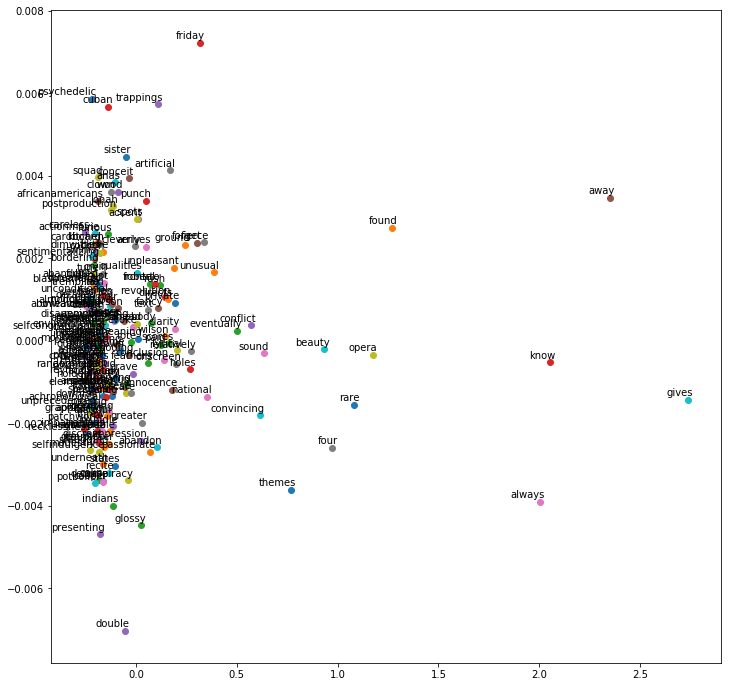

In [31]:
from sklearn.decomposition import PCA

def plot_with_labels(low_dim_embs, labels):
  plt.figure(figsize=(12, 12))
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')

n_plot = 200
pca = PCA(n_components=2)
result = pca.fit_transform(final_embeddings[:n_plot, :])

labels = [words[i] for i in range(n_plot)]
plot_with_labels(result, labels)

In [32]:
## build vocabulary

def count_data(words, n_words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(n_words - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  unk_count = 0
  for word in words:
    index = dictionary.get(word, 0)
    if index == 0:
      unk_count += 1
  count[0][1] = unk_count
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return count, dictionary, reversed_dictionary

## words are indexed by overall frequency in the dataset, 
## so that for instance the integer "3" encodes the 3rd most frequent word in the data. 
def build_data(sep_words):
  data = list()
  for lst in clean_words:
    sent = list()
    for w in lst:
      if w in dictionary.keys():
        sent.append(dictionary[w])
      else:
        sent.append(dictionary["UNK"])
    data.append(sent)
  return data

vocab_size = 10000
all_words = np.concatenate(clean_words)
count, dictionary, reverse_dictionary = count_data(all_words, vocab_size)
data = build_data(clean_words)

print('Most common words (+UNK)', count[:10])
print("5 sample sentences:")
for i in range(5):
    print([reverse_dictionary[j] for j in data[i]], data[i], sep="\n")

Most common words (+UNK) [['UNK', 10103], ('film', 1453), ('movie', 1270), ('one', 727), ('like', 721), ('story', 477), ('much', 386), ('even', 382), ('good', 377), ('comedy', 359)]
5 sample sentences:
['simplistic', 'silly', 'tedious']
[1021, 196, 526]
['UNK', 'juvenile', 'teenage', 'boys', 'could', 'possibly', 'find', 'funny']
[0, 2847, 1667, 708, 34, 993, 121, 15]
['exploitative', 'largely', 'devoid', 'depth', 'sophistication', 'would', 'make', 'watching', 'graphic', 'treatment', 'crimes', 'bearable']
[2145, 776, 1061, 572, 4662, 30, 16, 100, 1832, 1030, 1175, 7303]
['UNK', 'UNK', 'potential', 'UNK', 'study', 'UNK', 'instead', 'skewed', 'melodrama', 'circumstantial', 'situation']
[0, 0, 655, 0, 254, 0, 194, 5586, 322, 8967, 700]
['visually', 'flashy', 'narratively', 'opaque', 'emotionally', 'vapid', 'exercise', 'style', 'UNK']
[421, 1739, 3802, 3255, 505, 2540, 291, 178, 0]


In [33]:
## embedding + LSTM
from keras.layers.embeddings import Embedding
from keras.layers import LSTM
from keras.preprocessing import sequence
np.random.seed(7)

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=99, stratify=y)

vector_length = 100
sentence_length = 24

X_train = sequence.pad_sequences(X_train, maxlen=sentence_length)
X_test = sequence.pad_sequences(X_test, maxlen=sentence_length)

#print(X_train.shape, X_test.shape)
#print(X_train[:10])

In [34]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=vector_length, input_length=sentence_length))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=32)
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 24, 100)           1000000   
_________________________________________________________________
dropout_11 (Dropout)         (None, 24, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 1,042,305
Trainable params: 1,042,305
Non-trainable params: 0
_________________________________________________________________
None
Train on 8529 samples, validate on 2133 samples
Epoch 1/3
8529/8529 [==============================] - 17s 2ms/step - loss: 0.6

In [35]:
## Embedding + LSTM + CNN
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=vector_length, input_length=sentence_length))
model.add(Dropout(0.5))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 24, 100)           1000000   
_________________________________________________________________
dropout_13 (Dropout)         (None, 24, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 24, 32)            9632      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 6, 32)             0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 6, 32)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
__________

In [36]:
## long reviews from IMDb 
## load directly from keras
from keras.datasets import imdb

vocab_size = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)

sentence_length = 500
embed_vecor_length = 32

X_train = sequence.pad_sequences(X_train, maxlen=sentence_length)
X_test = sequence.pad_sequences(X_test, maxlen=sentence_length)

model = Sequential()
model.add(Embedding(vocab_size, embed_vecor_length, input_length=sentence_length))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=3, batch_size=64)

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
dropout_16 (Dropout)         (None, 500, 32)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
25000/25000 [==============================] - 285s 11ms/step - loss: 0.5016 - acc: 0.7423
Epoch 2/3
25000/25000 [==============================] - 251s 10ms/step - loss: 0.3060 - acc: 0.8751
Epoch 3/3
25000/25000 [==============================] - 258s

## 2. Multi-class classification

In [37]:
## import data
origin_data = pd.read_csv("data/kaggle.tsv", sep='\t')

X = origin_data["Phrase"].values
y = origin_data["Sentiment"].values

origin_data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [38]:
pd.value_counts(y)

2    79582
3    32927
1    27273
4     9206
0     7072
dtype: int64

In [39]:
def clean_sentence(text, rm_stopwords=True):
    """
    - Tokenize the words.
    - Remove all punctuation from words.
    - Remove all words that are not purely comprised of alphabetical characters.
    """
    
    text=text.lower()
    tokens = text.split()
    
    table = str.maketrans("","", string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    
    tokens = [w for w in tokens if w.isalpha()]
    return tokens

clean_corpus = []
clean_words = []
for s in X:
    clean_words.append(clean_sentence(s))
    clean_corpus.append(" ".join(clean_sentence(s)))

print(clean_words[:10])
print(clean_corpus[:10])
print("Length of X:", len(clean_corpus))

[['a', 'series', 'of', 'escapades', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose', 'is', 'also', 'good', 'for', 'the', 'gander', 'some', 'of', 'which', 'occasionally', 'amuses', 'but', 'none', 'of', 'which', 'amounts', 'to', 'much', 'of', 'a', 'story'], ['a', 'series', 'of', 'escapades', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose'], ['a', 'series'], ['a'], ['series'], ['of', 'escapades', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose'], ['of'], ['escapades', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose'], ['escapades'], ['demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose']]
['a series of escapades demonstrating the adage that what is good for the goose is also good for the gander some of which occasionally amuses but none of which amounts to much of a story', 'a series of escapades demonstrating the 

In [42]:
all_words = np.concatenate(clean_words)
count, dictionary, reverse_dictionary = count_data(all_words, vocab_size)
data = build_data(clean_words)
vocab_size = 10000

print('Most common words (+UNK)', count[:10])
print("5 sample sentences:")
for i in range(5):
    print([reverse_dictionary[j] for j in data[i]], data[i], sep="\n")

Most common words (+UNK) [['UNK', 123592], ('the', 51220), ('a', 36130), ('of', 32308), ('and', 31763), ('to', 22448), ('s', 17002), ('in', 13745), ('is', 13447), ('that', 12327)]
5 sample sentences:
['a', 'series', 'of', 'UNK', 'UNK', 'the', 'UNK', 'that', 'what', 'is', 'good', 'for', 'the', 'goose', 'is', 'also', 'good', 'for', 'the', 'UNK', 'some', 'of', 'which', 'occasionally', 'UNK', 'but', 'none', 'of', 'which', 'amounts', 'to', 'much', 'of', 'a', 'story']
[2, 304, 3, 0, 0, 1, 0, 9, 52, 8, 49, 13, 1, 3490, 8, 169, 49, 13, 1, 0, 62, 3, 75, 617, 0, 19, 576, 3, 75, 2012, 5, 54, 3, 2, 40]
['a', 'series', 'of', 'UNK', 'UNK', 'the', 'UNK', 'that', 'what', 'is', 'good', 'for', 'the', 'goose']
[2, 304, 3, 0, 0, 1, 0, 9, 52, 8, 49, 13, 1, 3490]
['a', 'series']
[2, 304]
['a']
[2]
['series']
[304]


In [43]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=99, stratify=y)

sent_lens = [len(s) for s in clean_words]
sentence_length = np.round((np.mean(sent_lens) + 2*np.std(sent_lens))).astype(int)
vector_length = 100

X_train = sequence.pad_sequences(X_train, maxlen=sentence_length)
X_test = sequence.pad_sequences(X_test, maxlen=sentence_length)

print("Shape of train-test data:", X_train.shape, X_test.shape)

Y_train = keras.utils.to_categorical(y_train, 5)
Y_test   = keras.utils.to_categorical(y_test, 5)

Shape of train-test data: (109242, 20) (46818, 20)


In [44]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=vector_length, input_length=sentence_length))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=3, batch_size=32)
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 20, 100)           1000000   
_________________________________________________________________
dropout_17 (Dropout)         (None, 20, 100)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 325       
Total params: 1,042,565
Trainable params: 1,042,565
Non-trainable params: 0
_________________________________________________________________
None
Train on 109242 samples, validate on 46818 samples
Epoch 1/3
109242/109242 [==============================] - 150s 1ms/step - loss: 1.0188 - acc: 0.5922 - val_loss: 0.9251 - val_acc: 0.6292
Epoch 2/3
109242/109242 [==============================] - 141s 1ms/s

In [ ]:
## An alternative way to train a word2vec with tensorflow

vocabulary_size = 1000
def build_dataset(words, n_words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(n_words - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    index = dictionary.get(word, 0)
    if index == 0:
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reversed_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(
    vocabulary, vocabulary_size)

print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  if data_index + span > len(data):
    data_index = 0
  buffer.extend(data[data_index:data_index + span])
  data_index += span
  for i in range(batch_size // num_skips):
    context_words = [w for w in range(span) if w != skip_window]
    words_to_use = random.sample(context_words, num_skips)
    for j, context_word in enumerate(words_to_use):
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[context_word]
    if data_index == len(data):
      buffer.extend(data[0:span])
      data_index = span
    else:
      buffer.append(data[data_index])
      data_index += 1
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0],
        reverse_dictionary[labels[i, 0]])

print("shape of batch:", batch.shape, "shape of labels:", labels.shape)

In [ ]:
batch_size = 64
embedding_size = 512  # Dimension of the embedding vector.
skip_window = 4  # How many words to consider left and right.
num_skips = 4  # How many times to reuse an input to generate a label.
num_sampled = 64  # Number of negative examples to sample, used to adjust the weights.

valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

graph = tf.Graph()
with graph.as_default():

  with tf.name_scope('inputs'):
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  with tf.device('/cpu:0'):
    with tf.name_scope('embeddings'):
      embeddings = tf.Variable(
          tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
      embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    with tf.name_scope('weights'):
      nce_weights = tf.Variable(
          tf.truncated_normal(
              [vocabulary_size, embedding_size],
              stddev=1.0 / math.sqrt(embedding_size)))
    with tf.name_scope('biases'):
      nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.nce_loss(
            weights=nce_weights,
            biases=nce_biases,
            labels=train_labels,
            inputs=embed,
            num_sampled=num_sampled,
            num_classes=vocabulary_size))

  with tf.name_scope('optimizer'):
    optimizer = tf.train.GradientDescentOptimizer(.1).minimize(loss)

  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                     valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

  init = tf.global_variables_initializer()

In [ ]:
# training.
num_steps = 10001
with tf.Session(graph=graph) as session:
  init.run()
  print('Initialized')

  average_loss = 0
  for step in range(num_steps):
    batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
    run_metadata = tf.RunMetadata()

    _, loss_val = session.run(
        [optimizer, loss],
        feed_dict=feed_dict,
        run_metadata=run_metadata)
    average_loss += loss_val

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      print('Average loss at step ', step, ': ', average_loss)
      average_loss = 0
    
    if step % 20000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = '%s %s,' % (log_str, close_word)
        print(log_str)
  final_embeddings = normalized_embeddings.eval()

In [ ]:
def plot_with_labels(low_dim_embs, labels):
  plt.figure(figsize=(16, 16))
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')


tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=1000, method='exact')
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)